# 1 Graph Centralities

In [ ]:
# Packages
import numpy as np
import pandas as pd
from zipfile import ZipFile
import networkx as nx
from fastprogress import master_bar, progress_bar
from networkx.algorithms import centrality

from collections import defaultdict
import random as rd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/graph_based_recommendation_system'
%cd {PATH_FOLDER}

/content/gdrive/.shortcut-targets-by-id/1Qu7UOLxDtaHg6JbrDo0q-3e4ePr807CH/graph_based_recommendation_system


In [ ]:
%ls

data/                  GNN.ipynb                project_proposal.pdf
DataExploration.ipynb  GraphCentralities.ipynb  README.md
figures/               project_proposal.docx    saved_model/


Load graph

In [ ]:
G = nx.readwrite.edgelist.read_weighted_edgelist('./data/graph.edgelist')

Top elements to retrieve:

In [ ]:
num_tops = 10

## Load DataFrames

In [ ]:
# Loading dataset from .zip file
path_dataset = "data/dataset.zip"

with ZipFile(path_dataset, 'r') as zip_ref:
    all_path = zip_ref.namelist()
    print('Paths: ', all_path)
    
    df_anime = pd.read_csv(zip_ref.open(all_path[0]))
    df_rating = pd.read_csv(zip_ref.open(all_path[1]))

Paths:  ['anime.csv', 'rating.csv']


Elimination of rows that have Nan values

In [ ]:
#df_anime.dropna(inplace=True)
df_rating.dropna(inplace=True)

Elimination of all rating values whose anime doesn't have a description in file 'anime.csv'

In [ ]:
for i in df_rating.anime_id.unique():
  if df_anime[df_anime['anime_id'] == i].empty:
    df_rating = df_rating[df_rating['anime_id'] != i]

Elimination of all user-item interactions when a rate has not been given (rating = -1)

In [ ]:
# number of user that have seen an anime, but didn't give a rate (meaning rating = -1)
df_rating[df_rating['rating'] == -1].rating.value_counts()

-1    1476488
Name: rating, dtype: int64

In [ ]:
# new dataframe without user-item intercations with rating = -1
new_df_rating = df_rating[df_rating['rating'] != -1]
assert(new_df_rating.shape[0] == df_rating.shape[0] - 1476488)

df_rating = new_df_rating
del new_df_rating

Number of possible nodes and edges after the pre-processing phase

In [ ]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  79526
Number of edges:  6337239


## 1.1 Degree centrality
Without considering that the graph is bipartite

In [ ]:
%%time
degree_centrality = centrality.degree_centrality(G)

CPU times: user 90.8 ms, sys: 4.97 ms, total: 95.8 ms
Wall time: 97.7 ms


In [ ]:
# Sort dictionary by value
degree_centrality = {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(degree_centrality, orient='index')
_.to_csv('./data/degree.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_degreeU = []
top_degreeA = []

for k in degree_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_degreeU.append((k, degree_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_degreeA.append((k, degree_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_degreeU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_degreeA:
  print('{}    {}'.format(k,v))

Top users:
user_42635    0.0471172587236718
user_53698    0.0365293932725558
user_57620    0.03381326626846903
user_59643    0.03309651053127947
user_51693    0.03295818924866394
user_45659    0.03095881798176674
user_7345    0.030543854133920148
user_12431    0.029525306507387612
user_65840    0.0278528764539453
user_22434    0.025036152153410877
--------------

Top anime:
anime_1535    0.4303803835271927
anime_11757    0.3308267840301792
anime_16498    0.3180006287331028
anime_1575    0.30336372209996854
anime_6547    0.2963219113486325
anime_226    0.2958566488525621
anime_20    0.27753536623703234
anime_5114    0.27027978623074506
anime_121    0.26824269097767994
anime_2904    0.2656271612700409


## 1.2 Closeness centrality
Without considering that the graph is bipartite.  
Note: Basic implementation of **Eppstein-Wang Algorithm** for computing an approximate closeness centralic metric.  
_Wang, David Eppstein Joseph. "Fast approximation of centrality." Graph algorithms and applications 5.5 (2006): 39._  

For weighted graph, Dijkstra's algorithm will be used.

In [ ]:
def cost_path(G, edges_list, weight=None):
  result = 0
  if weight != None:
    for i in range(1, len(edges_list)):
      v = edges_list[i-1]
      u = edges_list[i]
      result += G[v][u][weight]
  else:
    result = len(edges_list) - 1
  return result

In [ ]:
rd.seed(1)

def approximateClosenessCentralities(G, k, weight=None):
  sum_v = defaultdict()
  for v in G.nodes:
    sum_v[v] = 0

  for i in range(k):
    v_i = rd.choice(list(G.nodes))

    if weight != None: sssp = nx.algorithms.shortest_paths.generic.shortest_path(G, source=v_i,weight=weight, method='dijkstra')
    else: sssp = nx.algorithms.shortest_paths.generic.shortest_path(G, source=v_i,weight=None)

    for v in G.nodes:
      if weight != None: sum_v[v] += cost_path(G, sssp[v], weight)
      else: sum_v[v] += cost_path(G, sssp[v])

  cc = defaultdict() #closeness centrality
  n = len(G.nodes)
  for v in G.nodes:
    if sum_v[v] != 0: 
      cc[v] = 1 / ((n * sum_v[v]) / (k *(n-1)))
    else: 
      cc[v] = 1

  return cc

### **Without weights**

In [ ]:
%%time
k = 150
closeness_centrality = approximateClosenessCentralities(G, 150)

CPU times: user 9min 12s, sys: 2.13 s, total: 9min 14s
Wall time: 9min 13s


In [ ]:
# Sort dictionary by value
closeness_centrality = {k: v for k, v in sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(closeness_centrality, orient='index')
_.to_csv('./data/closeness.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_closenessU = []
top_closenessA = []

for k in closeness_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_closenessU.append((k, closeness_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_closenessA.append((k, closeness_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_closenessU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_closenessA:
  print('{}    {}'.format(k,v))

Top users:
user_53698    0.5136921706315398
user_42635    0.49999371274803206
user_22434    0.4966824961073167
user_59643    0.4966824961073167
user_45659    0.49341484810661057
user_57620    0.49341484810661057
user_7345    0.490189914458855
user_9032    0.490189914458855
user_51693    0.490189914458855
user_1145    0.487006863066265
--------------

Top anime:
anime_1535    0.46011691357180867
anime_1575    0.42856603949831323
anime_11757    0.4261310051829819
anime_20    0.4261310051829819
anime_4224    0.4237234853796882
anime_121    0.4237234853796882
anime_226    0.4213430163607012
anime_16498    0.41898914476092075
anime_6547    0.4166614272900267
anime_2167    0.4143594304541703


### **With weights** (ratings in this case)

In [ ]:
%%time
k = 150
closeness_centrality = approximateClosenessCentralities(G, 150, 'weight')

CPU times: user 41min 50s, sys: 8.95 s, total: 41min 59s
Wall time: 41min 56s


In [ ]:
# Sort dictionary by value
closeness_centrality = {k: v for k, v in sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(closeness_centrality, orient='index')
_.to_csv('./data/closenessW.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_closenessU = []
top_closenessA = []

for k in closeness_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_closenessU.append((k, closeness_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_closenessA.append((k, closeness_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_closenessU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_closenessA:
  print('{}    {}'.format(k,v))

Top users:
user_24323    0.13513343587784651
user_36110    0.134648217077567
user_59235    0.12964400503406193
user_44929    0.12908615647539556
user_5    0.12583734381242417
user_19592    0.12552143416268588
user_29075    0.12541648313077727
user_19509    0.1248943495623727
user_58974    0.12458315101695153
user_45010    0.12365879128145889
--------------

Top anime:
anime_226    0.1293087188141462
anime_19315    0.12908615647539556
anime_225    0.12875374577202542
anime_413    0.12842304265788496
anime_8074    0.1283131854785369
anime_2476    0.128203516089239
anime_9515    0.1277667068351019
anime_6205    0.12765796921226352
anime_1195    0.1274410482790226
anime_355    0.1274410482790226


### **With weights** (ratings function)
\begin{equation}
f(x) = - x^2 + 110
\end{equation}
where $x \in [0,10]$

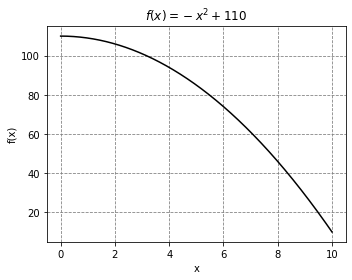

In [ ]:
x = np.linspace(0, 10, 1000)
y = -x**2+110 
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(x, y, color='k')

'''
# highlight
x = np.linspace(0, 10, 1000)
y = -x**2+110 
ax.fill_between(x, y-2, y+2, color='limegreen', alpha=0.5)
'''

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'$f(x) = - x^2 + 110$')
plt.grid(color='gray', linestyle='--')
plt.tight_layout()
plt.savefig('./figures/function_weights.jpg')
plt.show()

In [ ]:
G_prime = G.copy()
for e in progress_bar(list(G_prime.edges(data=True))):
  v = e[0] #node
  u = e[1] #node
  w = e[2]['weight']

  # apply function f(x) = -x^2+110
  w2 = -w**2+110

  # update weight on the graph
  G_prime[v][u]['weight'] = w2

**Centrality computation**:

In [ ]:
%%time
k = 150
closeness_centralityFW = approximateClosenessCentralities(G_prime, 150, 'weight')

CPU times: user 52min 23s, sys: 8.63 s, total: 52min 32s
Wall time: 52min 33s


In [ ]:
# Sort dictionary by value
closeness_centralityFW = {k: v for k, v in sorted(closeness_centralityFW.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(closeness_centralityFW, orient='index')
_.to_csv('./data/closenessFW.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_closenessU = []
top_closenessA = []

for k in closeness_centralityFW.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_closenessU.append((k, closeness_centralityFW[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_closenessA.append((k, closeness_centralityFW[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_closenessU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_closenessA:
  print('{}    {}'.format(k,v))

Top users:
user_61110    0.03990372807246864
user_21160    0.03970304759777915
user_31005    0.0381674589883994
user_49056    0.03813834574737087
user_66863    0.037954988315893126
user_26566    0.03794538675041984
user_30346    0.03757467781172586
user_18579    0.03743401892298718
user_26356    0.03735943059138471
user_25773    0.03722037563881132
--------------

Top anime:
anime_5114    0.033355150950502475
anime_11757    0.0332148170558923
anime_1535    0.03282952808588523
anime_2001    0.03265087371014576
anime_4181    0.032622469296304836
anime_1575    0.03253049529915628
anime_2904    0.03245307525409122
anime_16498    0.032383012483680834
anime_9253    0.03220917196143647
anime_226    0.03194167670877548


## 1.3 Degree centrality - Bipartite
Considering that the graph is bipartite

### Computation

In [ ]:
# Add user node features
for i in df_rating.user_id.unique():
  attrs = {'user_' + str(i): {'node_type':'user'}}
  nx.set_node_attributes(G, attrs)

# Add anime node features
for i in df_rating.anime_id.unique():
  attrs = {'anime_' + str(i): {'node_type':'anime'}}
  nx.set_node_attributes(G, attrs)

In [ ]:
anime_nodes = []
for id,t in G.nodes(data='node_type'):
  if t == 'anime':
    anime_nodes.append(id)

In [ ]:
%%time
degree_centrality = nx.algorithms.bipartite.centrality.degree_centrality(G, anime_nodes)

CPU times: user 174 ms, sys: 2 ms, total: 176 ms
Wall time: 186 ms


In [ ]:
# Sort dictionary by value
degree_centrality = {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
_ = pd.DataFrame.from_dict(degree_centrality, orient='index')
_.to_csv('./data/degreeB.csv', header=False)

In [ ]:
u = 0 #top users
a = 0 #top anime

top_degreeU = []
top_degreeA = []

for k in degree_centrality.keys():
  if k[:4] == 'user' and u < num_tops:
    u += 1
    top_degreeU.append((k, degree_centrality[k]))
  elif k[:5] == 'anime' and a < num_tops:
    a += 1
    top_degreeA.append((k, degree_centrality[k]))
  if u == num_tops and a == num_tops:
    break

In [ ]:
print('Top users:')
for k,v in top_degreeU:
  print('{}    {}'.format(k,v))

print('--------------\n')

print('Top anime:')
for k,v in top_degreeA:
  print('{}    {}'.format(k,v))

Top users:
user_42635    0.3774934515414064
user_53698    0.2926657263751763
user_57620    0.27090469474108403
user_59643    0.2651622002820875
user_51693    0.2640539995970179
user_45659    0.24803546242192223
user_7345    0.2447108603667137
user_12431    0.23655047350392908
user_65840    0.2231513197662704
user_22434    0.2005843239975821
--------------

Top anime:
anime_1535    0.4917528735632184
anime_11757    0.3780028735632184
anime_16498    0.3633477011494253
anime_1575    0.3466235632183908
anime_6547    0.33857758620689654
anime_226    0.33804597701149425
anime_20    0.31711206896551725
anime_5114    0.30882183908045974
anime_121    0.3064942528735632
anime_2904    0.3035057471264368


## 1.4 Top anime Comparison

Sort by rating

In [ ]:
df_anime.sort_values(by=['rating'], ascending=False).iloc[:10, 5]

10464    10.00
10400     9.60
9595      9.50
0         9.37
9078      9.33
1         9.26
2         9.25
10786     9.25
3         9.17
4         9.16
Name: rating, dtype: float64

In [ ]:
prefA_r = []
for i in df_anime.sort_values(by=['rating'], ascending=False).iloc[:10, 5].index:
  name = df_anime.at[i, 'name']
  prefA_r.append(name)

Sort by members

In [ ]:
df_anime.sort_values(by=['members'], ascending=False).iloc[:10, 6]

40     1013917
86      896229
804     893100
1       793665
159     717796
19      715151
841     683297
3       673572
445     657190
131     633817
Name: members, dtype: int64

In [ ]:
prefA_m = []
for i in df_anime.sort_values(by=['members'], ascending=False).iloc[:10, 6].index:
  name = df_anime.at[i, 'name']
  prefA_m.append(name)

## 1.5 Final considerations

In [ ]:
# Load data
degree = pd.read_csv('./data/degree.csv', names=['ids', 'score'])
degreeB = pd.read_csv('./data/degreeB.csv', names=['ids', 'score'])
closeness = pd.read_csv('./data/closeness.csv', names=['ids', 'score'])
closenessW = pd.read_csv('./data/closenessW.csv', names=['ids', 'score'])
closenessFW = pd.read_csv('./data/closenessFW.csv', names=['ids', 'score'])

In [ ]:
def retrieve_topK(df, df_description, num_tops):
  u = 0 #top users
  a = 0 #top anime

  topU = []
  topA = []

  for k in df['ids'].to_list():
    if k[:4] == 'user' and u < num_tops:
      u += 1
      topU.append(k)
    elif k[:5] == 'anime' and a < num_tops:
      a += 1

      i = df_description[df_description['anime_id'] == int(k[6:])].index[0]
      name = df_description.at[i, 'name']

      topA.append(name)
    if u == num_tops and a == num_tops:
      break
  
  return [topU, topA]

In [ ]:
d_u = defaultdict()
d_a = defaultdict()

# degree
topU, topA = retrieve_topK(degree, df_anime, num_tops)
d_u['degree'] = topU
d_a['degree'] = topA

# degree B
topU, topA = retrieve_topK(degreeB, df_anime, num_tops)
d_u['degree B'] = topU
d_a['degree B'] = topA

# closeness 
topU, topA = retrieve_topK(closeness, df_anime, num_tops)
d_u['closeness'] = topU
d_a['closeness'] = topA

# closeness W 
topU, topA = retrieve_topK(closenessW, df_anime, num_tops)
d_u['closeness W'] = topU
d_a['closeness W'] = topA

# closeness FW 
topU, topA = retrieve_topK(closenessFW, df_anime, num_tops)
d_u['closeness FW'] = topU
d_a['closeness FW'] = topA

# global average ranking
d_a['global avg rank'] = prefA_r

# members
d_a['members'] = prefA_m

In [ ]:
df_top_anime = pd.DataFrame(d_a)
df_top_user = pd.DataFrame(d_u)

### Top-k users rankings

In [ ]:
df_top_user

,degree,degree B,closeness,closeness W,closeness FW
0,user_42635,user_42635,user_53698,user_24323,user_61110
1,user_53698,user_53698,user_42635,user_36110,user_21160
2,user_57620,user_57620,user_22434,user_59235,user_31005
3,user_59643,user_59643,user_59643,user_44929,user_49056
4,user_51693,user_51693,user_45659,user_5,user_66863
5,user_45659,user_45659,user_57620,user_19592,user_26566
6,user_7345,user_7345,user_7345,user_29075,user_30346
7,user_12431,user_12431,user_9032,user_19509,user_18579
8,user_65840,user_65840,user_51693,user_58974,user_26356
9,user_22434,user_22434,user_1145,user_45010,user_25773


### Top-k anime rankings

In [ ]:
df_top_anime

,degree,degree B,closeness,closeness W,closeness FW,global avg rank,members
0,Death Note,Death Note,Death Note,Elfen Lied,Fullmetal Alchemist: Brotherhood,Taka no Tsume 8: Yoshida-kun no X-Files,Death Note
1,Sword Art Online,Sword Art Online,Code Geass: Hangyaku no Lelouch,Pupa,Sword Art Online,Spoon-hime no Swing Kitchen,Shingeki no Kyojin
2,Shingeki no Kyojin,Shingeki no Kyojin,Sword Art Online,Dragon Ball GT,Death Note,Mogura no Motoro,Sword Art Online
3,Code Geass: Hangyaku no Lelouch,Code Geass: Hangyaku no Lelouch,Naruto,Hametsu no Mars,Tengen Toppa Gurren Lagann,Kimi no Na wa.,Fullmetal Alchemist: Brotherhood
4,Angel Beats!,Angel Beats!,Toradora!,Highschool of the Dead,Clannad: After Story,Kahei no Umi,Angel Beats!
5,Elfen Lied,Elfen Lied,Fullmetal Alchemist,School Days,Code Geass: Hangyaku no Lelouch,Fullmetal Alchemist: Brotherhood,Code Geass: Hangyaku no Lelouch
6,Naruto,Naruto,Elfen Lied,Highschool of the Dead: Drifters of the Dead,Code Geass: Hangyaku no Lelouch R2,Gintama°,Naruto
7,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,Shingeki no Kyojin,Kämpfer,Shingeki no Kyojin,Yakusoku: Africa Mizu to Midori,Steins;Gate
8,Fullmetal Alchemist,Fullmetal Alchemist,Angel Beats!,Zero no Tsukaima,Steins;Gate,Steins;Gate,Mirai Nikki (TV)
9,Code Geass: Hangyaku no Lelouch R2,Code Geass: Hangyaku no Lelouch R2,Clannad,Shakugan no Shana,Elfen Lied,Gintama&#039;,Toradora!


### 1.5.1 A Similarity Measure for Indefinite Rankings (RBO)
Implementation from [link](https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899)  
Paper:[A Similarity Measure for Indefinite Rankings](http://w.codalism.com/research/papers/wmz10_tois.pdf)  

In general RBO is a similarity metrics which using weights for each rank position permits to have a comparison between rankings that can have different elements in their list. In addition disagreements between items at the top list have higher weights than the ones at the bottom.    

Let $S$ and $T$ two given rankings, then

\begin{equation}
RBO(S, T, p) = (1-p) \sum_{d=1}^{∞} p^{d-1} A_d
\end{equation}

where $d \in [1, \infty)$ is the ranking depth being examined, $X_d$ is the size of the overlap between the two given rankings up to depth $d$ and $A_d = \frac{X_d}{d}$. Also $p \in (0, 1)$ is a tunable parameter that can be used to determine the top $d$ ranks contribution to the final value of the RBO metric (the contribution of a single discordant pair decreases with the increase in the depth of the ranking).  
Some typical values are: $p=0.9$ and $d=10$. 

Assuming that the agreement seen up to a depth $k$ is continued indefinitely among the two lists. The single RBO score is:

\begin{equation}
RBO(S, T, p, k) = \frac{X_k}{k} \cdot p^k + \frac{1-p}{p} \sum_{d=1}^{k} \frac{X_d}{d} \cdot p^d
\end{equation}

In [ ]:
import math
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

**Users**

In [ ]:
categories = ['degree', 'degree B', 'closeness', 'closeness W', 'closeness FW']
rbo_values = np.zeros((len(categories), len(categories)), dtype=float)
for i, c_i in enumerate(categories):
  for j, c_j in enumerate(categories):
    rbo_metric = rbo(df_top_user[c_i].values, df_top_user[c_j].values)
    rbo_values[i,j] = rbo_metric
    print('RBO {} - {}: {}'.format(c_i, c_j, rbo_metric))

RBO degree - degree: 1.0
RBO degree - degree B: 1.0
RBO degree - closeness: 0.7120900274142856
RBO degree - closeness W: 0.0
RBO degree - closeness FW: 0.0
RBO degree B - degree: 1.0
RBO degree B - degree B: 1.0
RBO degree B - closeness: 0.7120900274142856
RBO degree B - closeness W: 0.0
RBO degree B - closeness FW: 0.0
RBO closeness - degree: 0.7120900274142856
RBO closeness - degree B: 0.7120900274142856
RBO closeness - closeness: 1.0
RBO closeness - closeness W: 0.0
RBO closeness - closeness FW: 0.0
RBO closeness W - degree: 0.0
RBO closeness W - degree B: 0.0
RBO closeness W - closeness: 0.0
RBO closeness W - closeness W: 1.0
RBO closeness W - closeness FW: 0.0
RBO closeness FW - degree: 0.0
RBO closeness FW - degree B: 0.0
RBO closeness FW - closeness: 0.0
RBO closeness FW - closeness W: 0.0
RBO closeness FW - closeness FW: 1.0


In [ ]:
# mask for low triangle
mask1 = np.tril(np.ones(rbo_values.shape)).astype(np.bool)
# mask for no diagonal
mask2 = np.ones(len(categories)) - np.identity(len(categories))
mask2 = mask2.astype(np.bool)

rbo_triangle = pd.DataFrame(rbo_values).where(np.multiply(mask1, mask2)).iloc[1:,:-1]
rbo_triangle.columns = categories[:-1]
rbo_triangle.index = categories[1:]

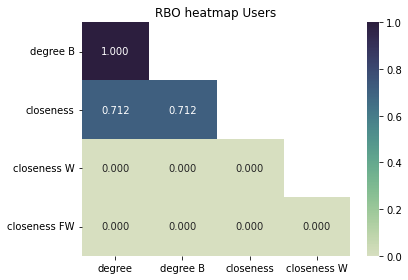

In [ ]:
mycmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
hmap=sns.heatmap(rbo_triangle, cmap=mycmap, annot=True, fmt=".3f")
plt.title('RBO heatmap Users')
plt.tight_layout()
hmap.figure.savefig("./figures/RBO_heatmap_users.png")

**Anime**

In [ ]:
categories = ['degree', 'degree B', 'closeness', 'closeness W', 'closeness FW', 'global avg rank', 'members']
rbo_values = np.zeros((len(categories), len(categories)), dtype=float)
for i, c_i in enumerate(categories):
  for j, c_j in enumerate(categories):
    rbo_metric = rbo(df_top_anime[c_i].values, df_top_anime[c_j].values)
    rbo_values[i,j] = rbo_metric
    print('RBO {} - {}: {}'.format(c_i, c_j, rbo_metric))

RBO degree - degree: 1.0
RBO degree - degree B: 1.0
RBO degree - closeness: 0.7445979821285715
RBO degree - closeness W: 0.0669372434357143
RBO degree - closeness FW: 0.5389972864071428
RBO degree - global avg rank: 0.04950372915000001
RBO degree - members: 0.7744486897642857
RBO degree B - degree: 1.0
RBO degree B - degree B: 1.0
RBO degree B - closeness: 0.7445979821285715
RBO degree B - closeness W: 0.0669372434357143
RBO degree B - closeness FW: 0.5389972864071428
RBO degree B - global avg rank: 0.04950372915000001
RBO degree B - members: 0.7744486897642857
RBO closeness - degree: 0.7445979821285715
RBO closeness - degree B: 0.7445979821285715
RBO closeness - closeness: 1.0
RBO closeness - closeness W: 0.05709574343571429
RBO closeness - closeness FW: 0.40575150835714285
RBO closeness - global avg rank: 0.0
RBO closeness - members: 0.651372269692857
RBO closeness W - degree: 0.0669372434357143
RBO closeness W - degree B: 0.0669372434357143
RBO closeness W - closeness: 0.05709574343

In [ ]:
# mask for low triangle
mask1 = np.tril(np.ones(rbo_values.shape)).astype(np.bool)
# mask for no diagonal
mask2 = np.ones(len(categories)) - np.identity(len(categories))
mask2 = mask2.astype(np.bool)

rbo_triangle = pd.DataFrame(rbo_values).where(np.multiply(mask1, mask2)).iloc[1:,:-1]
rbo_triangle.columns = categories[:-1]
rbo_triangle.index = categories[1:]

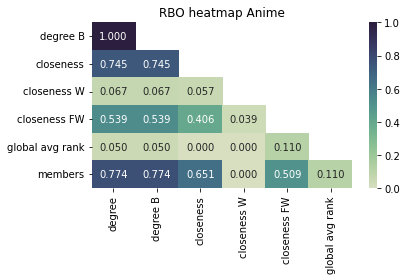

In [ ]:
mycmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
hmap=sns.heatmap(rbo_triangle, cmap=mycmap, annot=True, fmt=".3f")
plt.title('RBO heatmap Anime')
plt.tight_layout()
hmap.figure.savefig("./figures/RBO_heatmap_anime.png")

**Some final considerations**:  

1. Degree centrality computed with and without considering the property of the graph to be bipartite produces the same ranking list, even if the final scores are different.

2. Closeness centrality with graph **without weights** has a ranking quite similiar to the ones of degree centralies, but the order of some elements are different, while others are some new addition.

3. Closeness centrality with graph **with ratings as weight** is not really effective. This is due the fact that the weights in this case are rates which refelect how much an user had appreciated a certain item, but if used during the computation of the metric they are seen as distance lossing the original meaning. Indeed the output ranking is rather different compared with the others. For this reason a function $f(x) = -x^2+110$ is used to map ratings into "distances" somehow. For high rates we get low distances and decreasing the rate, the corresponding "distance" climp up.

4. It's interesting to observe that results obtained thanks graph analisys are not the same as sorting the anime by global avarage rating. A possible reason is that while the graph centrality metrics are calculated based on the given user-item interactions, the global avarage rating is, as the name suggests, only a mean value among ratings. Thus an anime watched by a small comunity that really likes it and so having a high global average rating, it may happen that it's not actually one of the most popular items. This assumption is supported by the fact that our metrics compared with the ranking given by sorting the anime by number of members are more similar.

5. It's important to rembember that graph G is huge, therefore computing the exact closeness metric is really difficult in terms of time complexity. For this reason, an approximeted version has been implemented with k=150 empiricaly chosen. It may be that increasing k value, so will happen for the effectiveness of closeness centrality. This is a possibile suggestion when more hardware resources are available.

6. Regarding the **time complexity**, on one hand degree centrality (for both versions) is really fast to compute, while closeness centrality requires 9 $\sim$ 10 minutes for the unweighted graph and 41/52 minutes for the weighted variants. Therefore considering that these centraly metrics will be used to solve the cold-start problem, a frequent occurance, having an operation that requires so much time, would be quite demanding. Thus degree centrality can be helpful when the operation is done with an high frequency, but if we decide to compute the most popular items to suggest and the most active users only from time to time (updating the values after a certain period has passed), then also closeness centrality could be used.

7. Analogous considerations done on points [1-3] are valid also for the analisys of **top k users rankings**. Interesting to note that while for anime rankings, closeness FW (closeness centrality with a function of ratings as weights) is similar to degree, degree B, closeness and memebers metrics, the same is not true comparing results for user rankings. 
A possible reason is that for **users** degree metrics and closeness centrality without weights, consider the top users the ones which are more active in terms of anime watched. On the other hand closeness with ratings as weights judges the users on the values of rates given. Same for closeness centrality with a function of ratings as weights, but with different final results obviously given by the application of the function $f(x)$.